In [1]:
import scanpy

scanpy.settings.verbosity = 3
scanpy.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.4


In [2]:
import pandas

# user-defined variables

In [3]:
counts_file = '/home/adrian/education/roger/data/GSE123813_scc_scRNA_counts.txt.gz'
metadata_file = '/home/adrian/education/roger/data/GSE123813_scc_metadata.txt.gz'

In [4]:
my_palette = [
    'grey', 'grey', 'grey', 'grey', 'grey', 'grey',
    'gold', 'skyblue', 'limegreen', 'tab:purple'
]

# read data

In [5]:
%%time
adata = scanpy.read_text(counts_file, first_column_names=True).transpose()    

CPU times: user 34.6 s, sys: 584 ms, total: 35.2 s
Wall time: 35.2 s


In [6]:
adata

AnnData object with n_obs × n_vars = 26016 × 18347

In [7]:
adata.var_names_make_unique()

In [8]:
adata

AnnData object with n_obs × n_vars = 26016 × 18347

# read metadata

In [9]:
anno = pandas.read_csv(metadata_file, sep='\t', index_col=0)
anno

,patient,treatment,cluster,UMAP1,UMAP2
cell.id,,,,,
scc.su010.post_AAACCTGAGACAAAGG,su010,post,CD8_mem,-2.155080,1.904121
scc.su010.post_AAACCTGAGACTAAGT,su010,post,CD8_ex,-1.547080,-1.710866
scc.su010.post_AAACCTGAGGCATGGT,su010,post,CD8_mem,-0.820249,0.311856
scc.su010.post_AAACCTGAGGGTCGAT,su010,post,Naive,2.743202,0.647236
scc.su010.post_AAACCTGAGGTACTCT,su010,post,Tfh,2.759312,0.526145
...,...,...,...,...,...
scc.su014.pre_TTTGTCAAGTGTTGAA,su014,pre,Th17,2.970795,-5.863445
scc.su014.pre_TTTGTCACAAATACAG,su014,pre,Th17,1.954126,-6.320317
scc.su014.pre_TTTGTCAGTCTAACGT,su014,pre,CD8_eff,-5.906037,-0.211607


They share UMAP positions but not the code, WTF?

In [10]:
adata.obs['reported_cell_types'] = anno['cluster']

# QC

normalizing counts per cell
    finished (0:00:01)


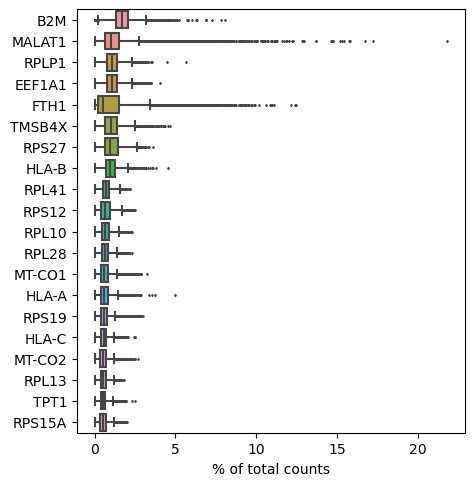

In [11]:
scanpy.pl.highest_expr_genes(adata, n_top=20)

In [12]:
scanpy.pp.filter_cells(adata, min_genes=200)
scanpy.pp.filter_genes(adata, min_cells=3)

filtered out 788 genes that are detected in less than 3 cells


In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
scanpy.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

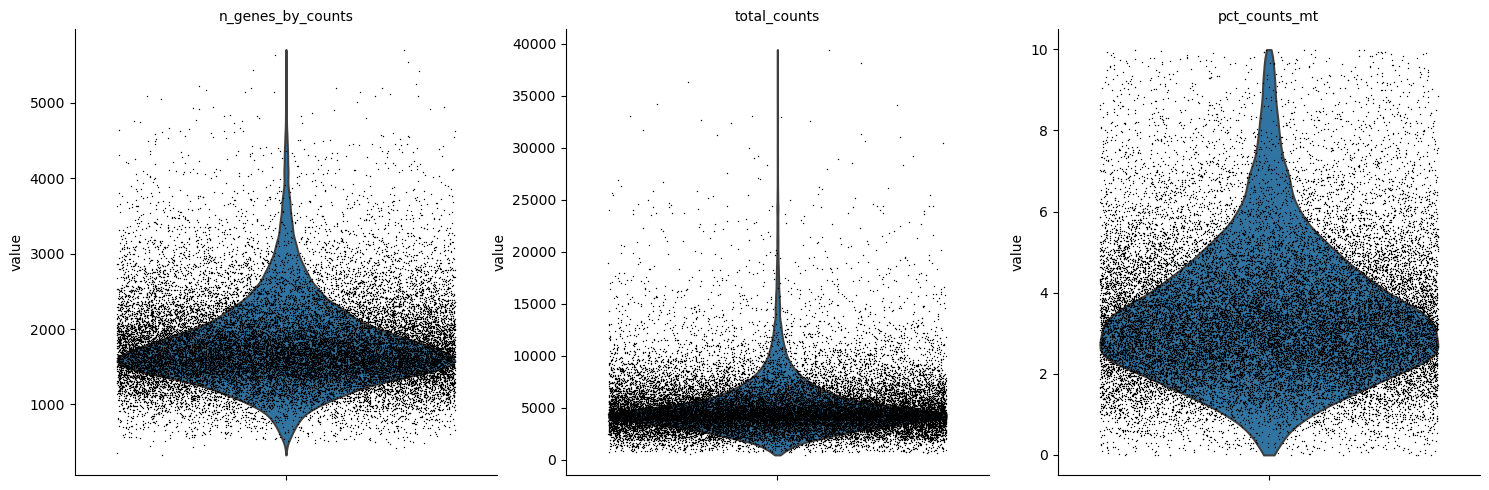

In [14]:
scanpy.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

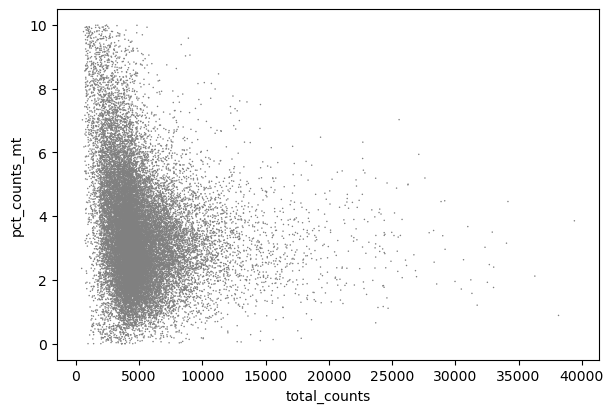

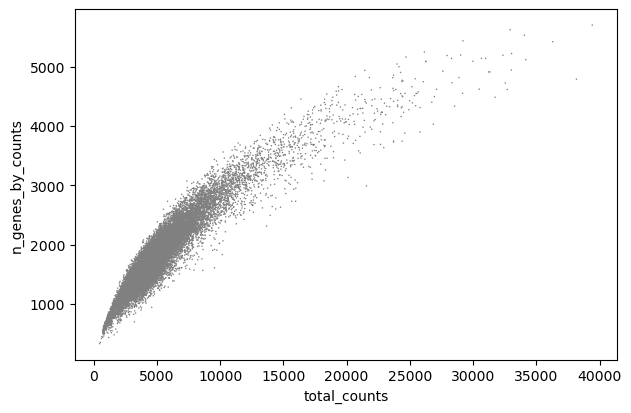

In [15]:
scanpy.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [16]:
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [17]:
scanpy.pp.normalize_total(adata, target_sum=1e4)
scanpy.pp.log1p(adata)

/home/adrian/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


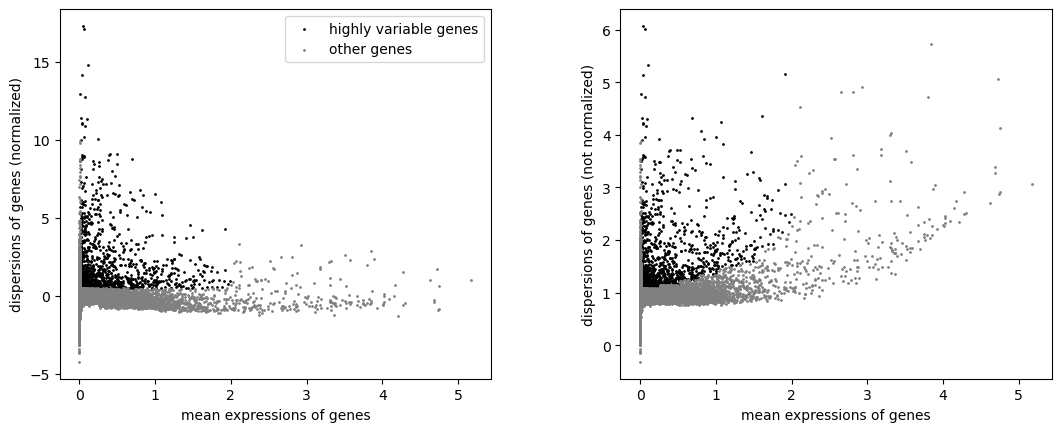

In [18]:
scanpy.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=2, min_disp=0.5)
scanpy.pl.highly_variable_genes(adata)

In [19]:
adata.raw = adata

In [20]:
adata = adata[:, adata.var.highly_variable]

In [21]:
scanpy.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:07)


In [22]:
scanpy.pp.scale(adata, max_value=10)

# Visualization

## PCA

In [23]:
scanpy.tl.pca(adata, svd_solver='arpack', n_comps=200)

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:06)


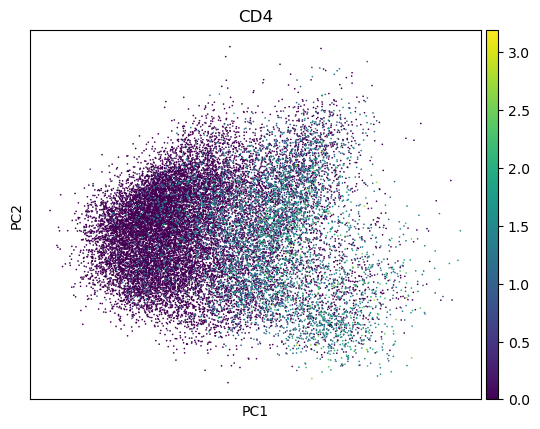

In [24]:
scanpy.pl.pca(adata, color='CD4')

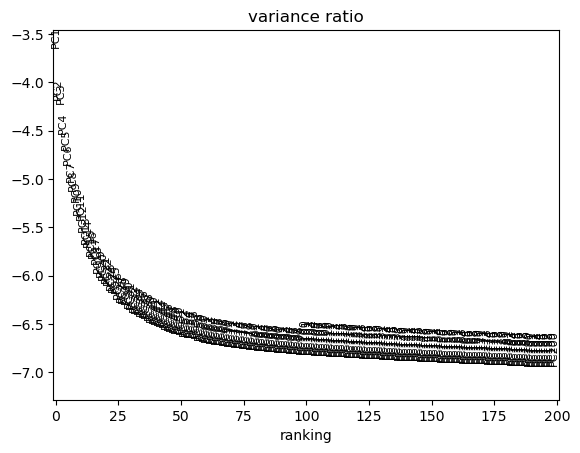

In [25]:
scanpy.pl.pca_variance_ratio(adata, log=True, n_pcs=200)

## UMAP

In [26]:
scanpy.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


In [27]:
scanpy.tl.leiden(adata)

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [28]:
scanpy.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


/home/adrian/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


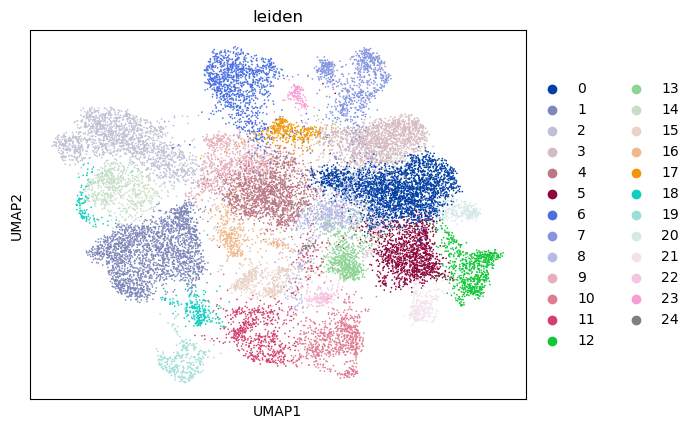

In [29]:
scanpy.pl.umap(adata, color='leiden')

In [30]:
scanpy.tl.paga(adata)
scanpy.pl.paga(adata, plot=False)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


/home/adrian/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


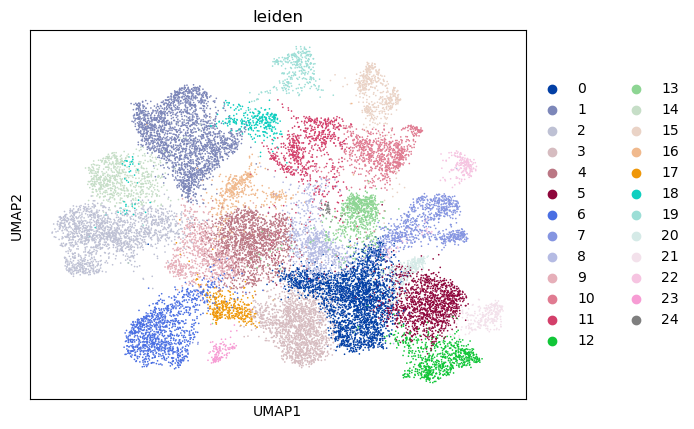

In [31]:
scanpy.tl.umap(adata, init_pos='paga')
scanpy.pl.umap(adata, color='leiden')

### overlay metadata

/home/adrian/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


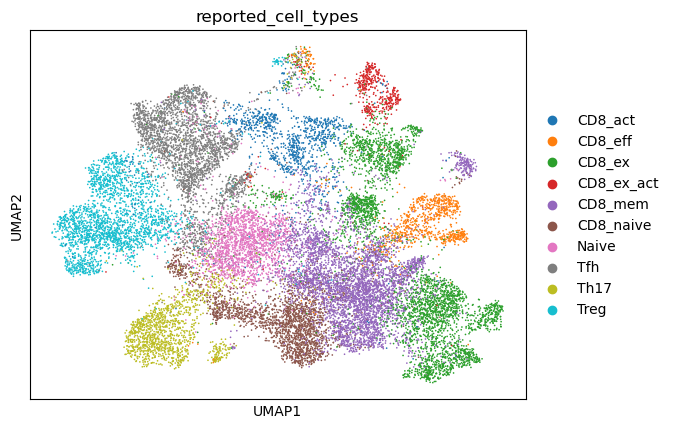

In [32]:
scanpy.pl.umap(adata, color='reported_cell_types')

/home/adrian/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


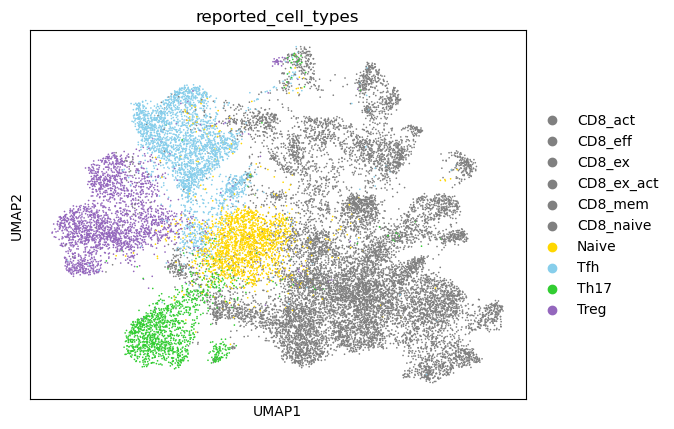

In [33]:
scanpy.pl.umap(adata, color='reported_cell_types', palette=my_palette)